<a href="https://colab.research.google.com/github/daichira-gif/daichira/blob/main/PDF_to_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### APIキーの準備

In [1]:
import pathlib
import textwrap
import google.generativeai as genai
from google.colab import userdata
from IPython.display import display
from IPython.display import Markdown

# Markdown出力
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [3]:
# APIキーの準備
GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## 1.生成AIを使わずにPDFファイルを読み込み
- tabula-pyで読み込んでみる

In [4]:
!pip install tabula-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.6 MB/s eta 0:00:00


In [5]:
!pip install jpype1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 9.0 MB/s eta 0:00:00


### ファイルのアップロード

In [6]:
# ファイルのアップロードを促進するためのウィジェットをインポート
from google.colab import files
import tabula
import pandas as pd

# PDFファイルをアップロード
uploaded = files.upload()

# アップロードされたファイル名を取得
pdf_file = list(uploaded.keys())[0]

# PDFファイルから表を抽出
tables = tabula.read_pdf(pdf_file, pages='all', multiple_tables=True)

Saving 公共施設白書_市営住宅.pdf to 公共施設白書_市営住宅.pdf


In [7]:
# 読み込んだ表を表示
for i, table in enumerate(tables, 1):
    print(f"Table {i}:\n{table}\n")

Table 1:
           建物状況 管理状況  利用状況 Unnamed: 0 Unnamed: 1  Unnamed: 2 Unnamed: 3  \
0           施設名   区名    町名     建築\r年度      築\r年数  延床面積\r(m2)         棟数   
1         新松崎団地  門司区   松崎町       1979         43    4,509.58          3   
2          丸山団地  門司区    丸山       1963         59   12,513.04         10   
3         緑ケ丘団地  門司区   緑ケ丘       1966         56   12,475.36         10   
4         大久保団地  門司区   大久保       1975         47    2,560.20          4   
5         折戸口団地  門司区   大久保       1969         53    5,622.70          5   
6    上本町団地(門司区)  門司区   花月園       1970         52    8,519.16          9   
7          片上団地  門司区   片上町       1975         47    7,336.90          7   
8         新門司団地  門司区    吉志       1976         46    1,069.20          1   
9       新門司第二団地  門司区    吉志       1978         44    1,345.05          2   
10      吉志さくら団地  門司区    吉志       2008         14    1,409.05          2   
11         北川団地  門司区   北川町       1971         51    5,174.82          8   
12         古城団地 

## 結果

In [ ]:
# 各表をpandas DataFrameとして表示
df = tables[3]
df

## 2.画像変換してからOCRで読み込み

In [9]:
!apt-get install poppler-utils
!apt-get install tesseract-ocr-jpn
!apt-get install libtesseract-dev
!pip install Pillow
!pip install pytesseract
!pip install pdf2image
!pip install tiktoken
!pip install typing-extensions

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 2s (119 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesse

In [10]:
from google.colab import files
import pandas as pd
import os

# PDFファイルをアップロード
uploaded = files.upload()
# アップロードされたファイル名を取得
pdf_file = list(uploaded.keys())[0]

Saving 公共施設白書_市営住宅.pdf to 公共施設白書_市営住宅 (1).pdf


In [12]:
from pdf2image import convert_from_path
from PIL import ImageEnhance, ImageFilter, Image
import pytesseract
!wget https://github.com/tesseract-ocr/tessdata/blob/main/jpn.traineddata

# PDFからテキストを抽出する関数を定義
def ocr_from_pdf(file_path):
    # convert_from_path関数を使ってPDFファイルを画像に変換
    images = convert_from_path(file_path)

    # 抽出したテキストを保存するための空の文字列を作成
    text = ''

    # 画像リストの各画像について
    for i in range(len(images)):
        # pytesseractのimage_to_string関数を使って画像からテキストを抽出し、
        # text変数に追加。langパラメータに'jpn'を指定して日本語のテキストを認識
        pytesseract.pytesseract.tesseract_cmd = (
            r'/usr/bin/tesseract'
            )
        text += pytesseract.image_to_string(images[i], lang='jpn', config='hocr')

    # 全ての画像から抽出したテキストを返す
    return text

# 対象となるPDFファイルのパスを指定
file_path = '公共施設白書_市営住宅.pdf'

# ocr_from_pdf関数を使ってPDFからテキストを抽出
text = ocr_from_pdf(file_path)


--2024-01-01 13:49:16--  https://github.com/tesseract-ocr/tessdata/blob/main/jpn.traineddata
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14194 (14K) [text/plain]
Saving to: ‘jpn.traineddata.1’

jpn.traineddata.1   100%[===================>]  13.86K  --.-KB/s    in 0.001s  

2024-01-01 13:49:16 (9.64 MB/s) - ‘jpn.traineddata.1’ saved [14194/14194]



## 結果

In [13]:
# 抽出したテキストを表示
print(text)

] 市営住宅

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

建物状況                                            管理状況     利用状況
ュ               建築 | 貧 | 延床面積   | 複合の   了      Je |耐震| 面圭 | 建物| 。      。         管理 | 管理| 人へ屋
施設名       区名 | 町久生半生    醒数 | 人の| 主たる施設名    な構造 | 避計| 半 | 科物 | 所管局 | 所管課   種類 | た閉| 央| 人

新松崎団地         門司区 |松町 |1979| 43    450958| 3             鉄航コンクリート千 |実施済 |不要 | 市 |陸筑都市局 |住宅管理課 |公営住宅 |管理代行    64| ss5e
ュ                                        ae にか                ーー |公営住宅ノ |管理代行及

丸山団地          門司区 |丸山   1963| 59   12.513.04   10| 複合 |丸山団地     鉄筋コンクリート造 |実施済 |未実施  市 |建築都市局 |住宅管理課 改良住宅等 |び指定管理   226  59.3

緑ケ丘団地           門司区 |緑ケ丘   1966 | 56    12.475.36   10                鉄筋コンクリート造 |実施済 |不要    市 |建築都市局 |]住宅管理課 |公営住宅   管理代行    158   74.7

大久保団地         門司区 |大久保 |1975| 47    256020| 4             鉄筋コンクリート千 |実施済 |実施済 | 市 |陸筑都市局 |住宅管理課 |公営住宅 |管理代行    s0| 9o
ニ             =                                        ae にか    、            ーー |公営住宅ノ |管

## 3.生成AIでPDFファイルを読み込み

### パッケージのインストール

In [14]:
# パッケージのインストール

!pip install -q -U google-generativeai
!pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 3.1 MB/s eta 0:00:00


In [15]:
!apt-get install poppler-utils
!apt-get install tesseract-ocr-jpn
!apt-get install libtesseract-dev
!pip install Pillow
!pip install pytesseract
!pip install pdf2image
!pip install tiktoken
!pip install typing-extensions

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-jpn is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


### ファイルのアップロード

In [ ]:
from google.colab import files
import pandas as pd
import os

# PDFファイルをアップロード
uploaded = files.upload()
# アップロードされたファイル名を取得
pdf_file = list(uploaded.keys())[0]

In [17]:
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

# PDFファイルを画像に変換する関数
def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    return images

# 画像からテキストを抽出する関数
def extract_text_from_image(image):
    text = pytesseract.image_to_string(image)
    return text

### 画像に変換

In [19]:

# PDFファイルを指定
pdf_path = '公共施設白書_市営住宅.pdf'

# convert_from_path関数を使ってPDFファイルを画像に変換
images = convert_from_path(pdf_path)

#以下参考のため
## 画像からテキストを抽出
extracted_text = ''
for i, image in enumerate(images, 1):
    text = extract_text_from_image(image)
    extracted_text += f"Page {i}:\n{text}\n\n"

## 抽出したテキストを表示
#print(extracted_text)


In [20]:
for i in range(len(images)):
  images[i].save(f'photo{i}.jpg')

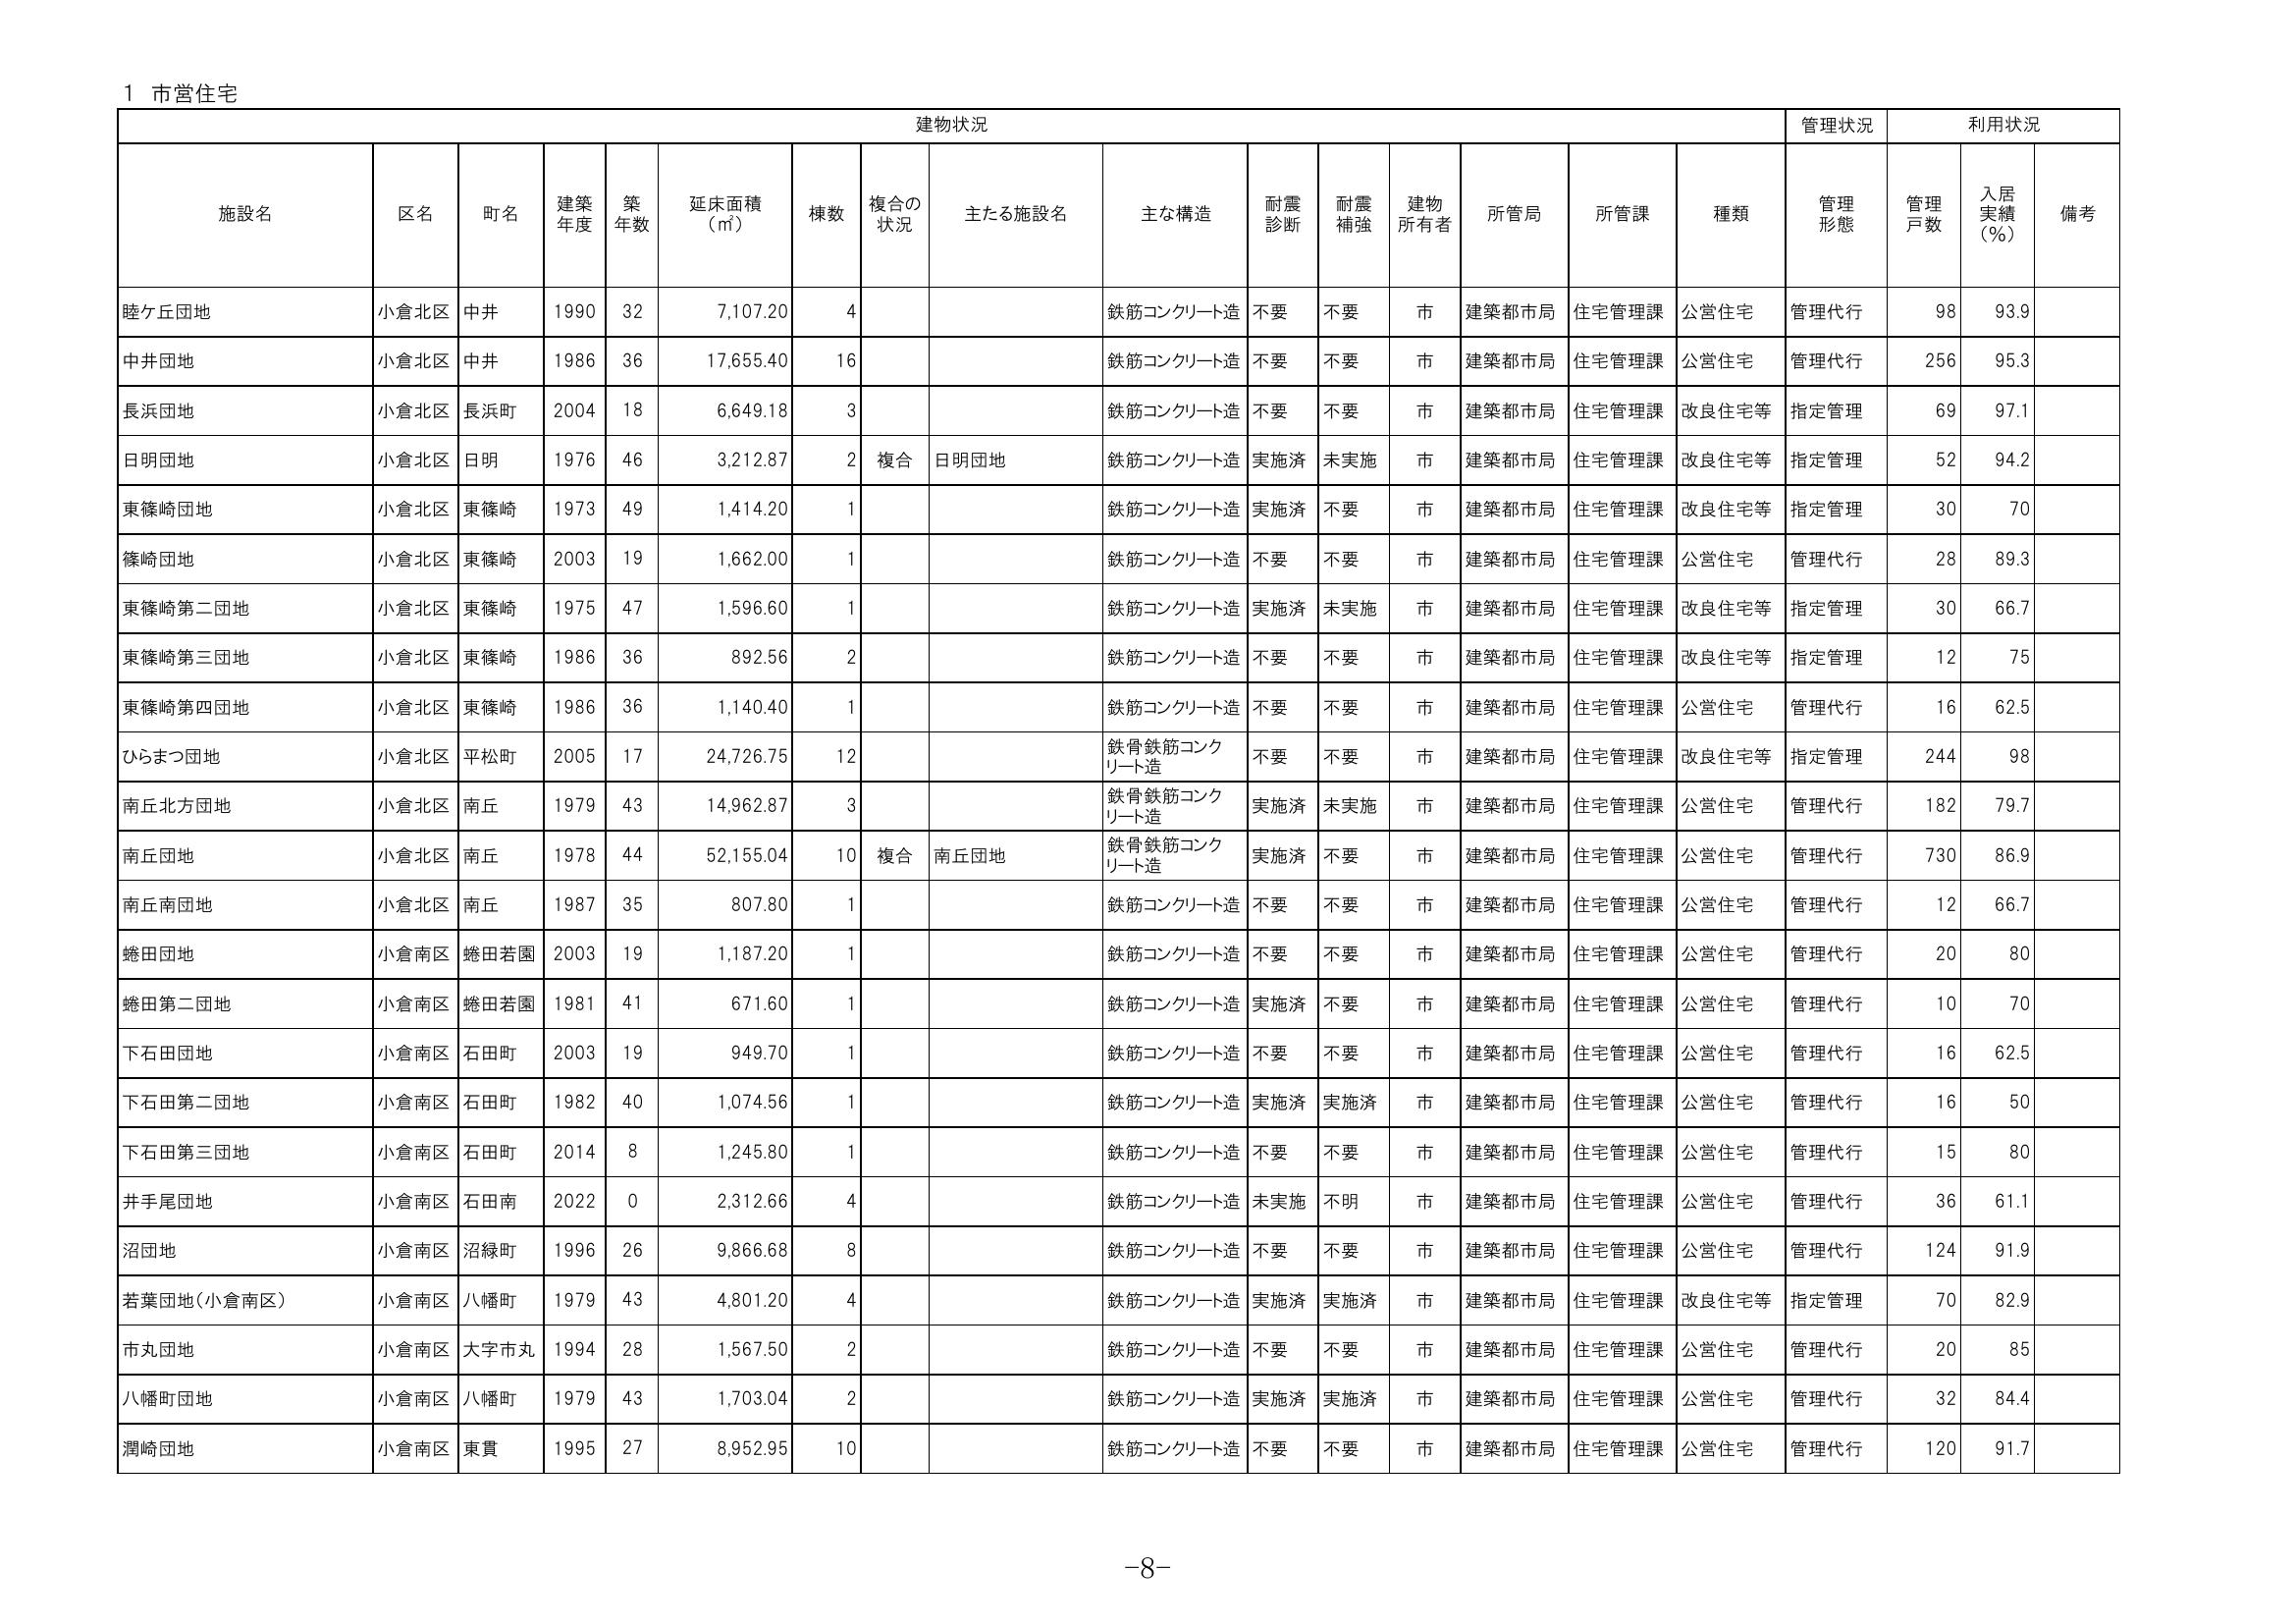

In [21]:

#　画像の読み込み
phototest = Image.open('photo5.jpg')
phototest

### テキスト読み込み

In [22]:
import pathlib
import textwrap
import google.generativeai as genai
from google.colab import userdata
from IPython.display import display
from IPython.display import Markdown

# Markdown出力
def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [23]:
import cv2
import os
from collections import deque
from datetime import datetime
from pydub import AudioSegment
from pydub.playback import play
import google.generativeai as genai
import PIL.Image
import numpy as np

def wrap_text(text, line_length):
    """テキストを指定された長さで改行する"""
    words = text.split(' ')
    lines = []
    current_line = ''

    for word in words:
        if len(current_line) + len(word) + 1 > line_length:
            lines.append(current_line)
            current_line = word
        else:
            current_line += ' ' + word

    lines.append(current_line)  # 最後の行を追加
    return lines

def add_text_to_frame(frame, text):
    # テキストを70文字ごとに改行
    wrapped_text = wrap_text(text, 70)

    # フレームの高さと幅を取得
    height, width = frame.shape[:2]

    # テキストのフォントとサイズ
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0  # フォントサイズを大きくする
    color = (255, 255, 255)  # 白色
    outline_color = (0, 0, 0)  # 輪郭の色（黒）
    thickness = 2
    outline_thickness = 4  # 輪郭の太さ
    line_type = cv2.LINE_AA

    # 各行のテキストを画像に追加
    for i, line in enumerate(wrapped_text):
        position = (10, 30 + i * 30)  # 各行の位置を調整（より大きい間隔）

        # テキストの輪郭を描画
        cv2.putText(frame, line, position, font, font_scale, outline_color, outline_thickness, line_type)

        # テキストを描画
        cv2.putText(frame, line, position, font, font_scale, color, thickness, line_type)

def save_frame(frame, filename, directory='./frames'):
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(directory):
        os.makedirs(directory)
    # ファイル名のパスを作成
    filepath = os.path.join(directory, filename)
    # フレームを保存
    cv2.imwrite(filepath, frame)

def save_temp_frame(frame, filename, directory='./temp'):
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(directory):
        os.makedirs(directory)
    # ファイル名のパスを作成
    filepath = os.path.join(directory, filename)
    # フレームを保存
    cv2.imwrite(filepath, frame)
    return filepath  # 保存したファイルのパスを返す

def send_frame_with_text_to_gemini(frame, previous_texts, timestamp, user_input, client):

    temp_file_path = save_temp_frame(frame, "temp.jpg")
    img = PIL.Image.open(temp_file_path)

    img = np.array(img)


    # 過去のテキストをコンテキストとして結合
    context = ' '.join(previous_texts)

    # Geminiモデルの初期化
    model = client.GenerativeModel('gemini-pro-vision')

    # モデルに画像とテキストの指示を送信
    prompt = f"Given the context: {context} and the current time: {timestamp}, please respond to the following message in Japanese without repeating the context. Message: {user_input}"
    img = Image.fromarray(frame)
    response = model.generate_content([prompt, img], stream=True)
    response.resolve()

    # 生成されたテキストを返す
    return response.text



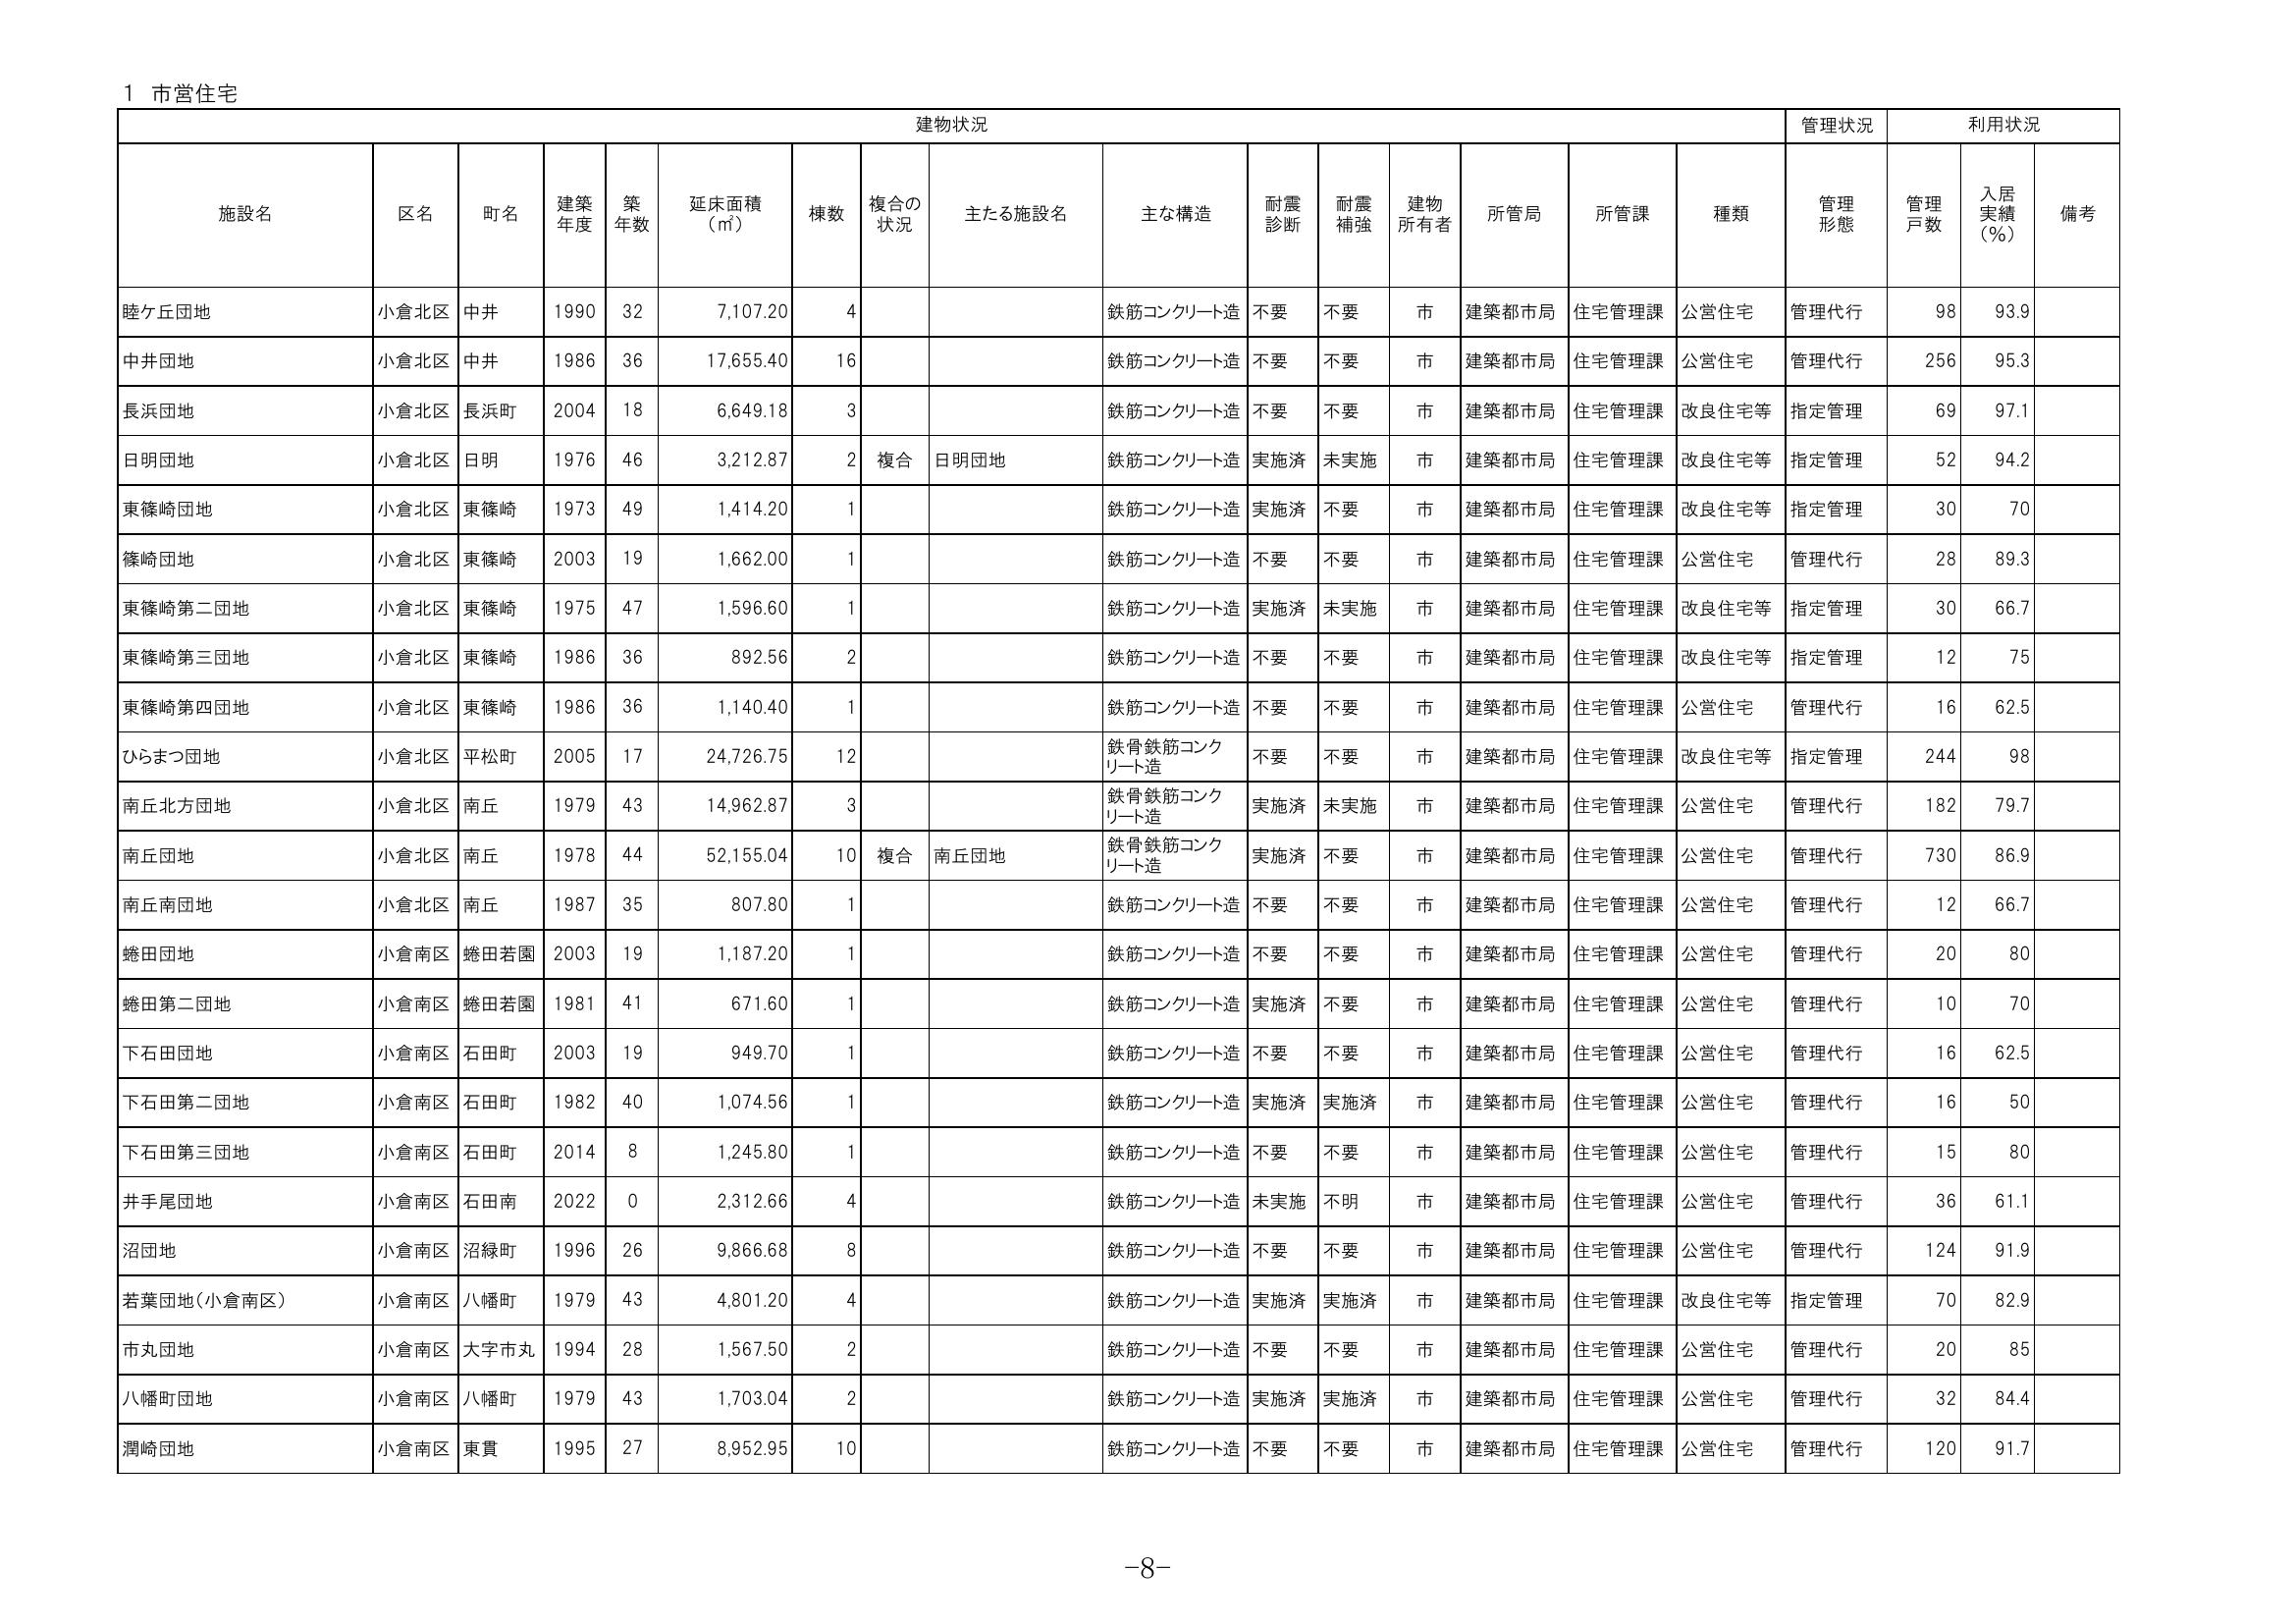

In [24]:

#　画像の読み込み
img2 = Image.open('photo5.jpg')
img2

In [25]:

def main():
    genai.configure(api_key=GOOGLE_API_KEY)
    filename = 'photo5.jpg'

    try:
         video = Image.open('photo5.jpg')

    except IOError as e:
        print(f"エラーが発生しました: {e}")
        return

    # 最近の5フレームのテキストを保持するためのキュー
    previous_texts = deque(maxlen=5)

    while True:

        print("新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:")
        user_input = input().strip()  # 入力を受け取る

        if user_input == "exit":
            print("了解しました。")
            break

        if not user_input:
            user_input = "Tell me what you see."

        frame = video
        frame = np.array(frame)

        # 現在のタイムスタンプを取得
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # geminiにフレームを送信し、生成されたテキストを取得
        generated_text = send_frame_with_text_to_gemini(frame, previous_texts, timestamp, user_input, genai)
        print(f"Timestamp: {timestamp}, Generated Text: {generated_text}")

        # タイムスタンプ付きのテキストをキューに追加
        previous_texts.append(f"[{timestamp}] Message: {user_input}, Generated Text: {generated_text}")

        # フレームにテキストを追加(日本語は文字化けします)
        text_to_add = f"{timestamp}: {generated_text}"

        add_text_to_frame(frame, text_to_add)

        # フレームを保存
        filename = f"{timestamp}.jpg"
        save_frame(frame, filename)

    # ビデオをリリースする
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:
この表を参照して、長浜団地の建築年度を教えてください。
Timestamp: 2024-01-01 13:54:30, Generated Text:  長浜団地の建築年度は、１９７５年です。
新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:
この表のデータを分析してください。
Timestamp: 2024-01-01 13:56:18, Generated Text:  表のデータを分析すると、長浜団地の建築年度は１９７５年であることがわかります。また、長浜団地の耐震診断結果は、おおむね良好であることがわかります。
新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:
exit
了解しました。


## 4.画像からテキスト読み込み + 生成AIで解釈
-> Gemini Pro Visionは画像しか読み込めないため、できなかった。


In [ ]:
# パッケージのインストール

!pip install -q -U google-generativeai
!pip install Pillow
!pip install pytesseract
!pip install pdf2image

In [ ]:
!apt-get install poppler-utils
!apt-get install tesseract-ocr-jpn
!apt-get install libtesseract-dev

In [ ]:
from google.colab import files
import pandas as pd
import os

# PDFファイルをアップロード
uploaded = files.upload()
# アップロードされたファイル名を取得
pdf_file = list(uploaded.keys())[0]

In [ ]:
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

# PDFファイルを画像に変換する関数
def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    return images

# 画像からテキストを抽出する関数
def extract_text_from_image(image):
    text = pytesseract.image_to_string(image, lang='jpn')
    return text

In [ ]:

# PDFファイルを指定
pdf_path = '公共施設白書_市営住宅.pdf'

# convert_from_path関数を使ってPDFファイルを画像に変換
images = convert_from_path(pdf_path)

## 画像からテキストを抽出
extracted_text = ''
for i, image in enumerate(images, 1):
    text = extract_text_from_image(image)
    extracted_text += f"Page {i}:\n{text}\n\n"

## 抽出したテキストを表示
#print(extracted_text)


In [ ]:
# モデルを準備
model = genai.GenerativeModel('gemini-pro-vision')


In [ ]:
response = model.generate_content([
    "この資料には、市営住宅の一覧表はありますか。",
    extracted_text
], stream=False)
response.resolve()
to_markdown(response.text)
